In [1]:
# Cell 1 — setup
!pip -q install transformers datasets accelerate==0.33.0

import os, json, math, collections
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from dataclasses import dataclass 
from typing import Dict, List, Tuple

import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from transformers import (
    AutoTokenizer, AutoModelForQuestionAnswering,
    default_data_collator, get_linear_schedule_with_warmup, set_seed
)
from datasets import Dataset, DatasetDict

set_seed(42)
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# Cell 2 — data paths + loader
DATA_DIR = "./"  # change if needed

TRAIN_JSON      = os.path.join(DATA_DIR, "spoken_train-v1.1.json")
TEST_CLEAN_JSON = os.path.join(DATA_DIR, "spoken_test-v1.1.json")
TEST_W44_JSON   = os.path.join(DATA_DIR, "spoken_test-v1.1_WER44.json")
TEST_W54_JSON   = os.path.join(DATA_DIR, "spoken_test-v1.1_WER54.json")

for p in [TRAIN_JSON, TEST_CLEAN_JSON, TEST_W44_JSON, TEST_W54_JSON]:
    assert os.path.exists(p), f"Missing file: {p}"

def load_squad_like(json_path: str) -> Dataset:
    with open(json_path, "r", encoding="utf-8") as f:
        js = json.load(f)
    contexts, questions, ids, answers = [], [], [], []
    for art in js["data"]:
        for par in art["paragraphs"]:
            ctx = par["context"]
            for qa in par["qas"]:
                qid = qa.get("id", str(len(ids)))
                q   = qa["question"]
                if qa.get("answers"):
                    a = qa["answers"][0]
                    a_text, a_start = a["text"], a["answer_start"]
                else:
                    a_text, a_start = "", 0
                contexts.append(ctx)
                questions.append(q)
                ids.append(qid)
                answers.append({"text":[a_text], "answer_start":[a_start]})
    return Dataset.from_dict({"id": ids, "context": contexts, "question": questions, "answers": answers})

train_ds  = load_squad_like(TRAIN_JSON)
clean_ds  = load_squad_like(TEST_CLEAN_JSON)
wer44_ds  = load_squad_like(TEST_W44_JSON)
wer54_ds  = load_squad_like(TEST_W54_JSON)

print(f"Train={len(train_ds)}, Clean={len(clean_ds)}, WER44={len(wer44_ds)}, WER54={len(wer54_ds)}")


Train=37111, Clean=5351, WER44=5351, WER54=5351


In [3]:
# Cell 3 — tokenizer + SAFE preprocess
MODEL_NAME = "bert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

MAX_LEN    = 384
DOC_STRIDE = 128

def prepare_train_features(examples):
    tok = tokenizer(
        examples["question"], examples["context"],
        truncation="only_second", max_length=MAX_LEN, stride=DOC_STRIDE,
        return_offsets_mapping=True, return_overflowing_tokens=True, padding="max_length",
    )
    sample_map  = tok.pop("overflow_to_sample_mapping")
    offsets_all = tok["offset_mapping"]

    start_pos, end_pos = [], []

    for i, offsets in enumerate(offsets_all):
        input_ids  = tok["input_ids"][i]
        seq_ids    = tok.sequence_ids(i)
        cls_index  = input_ids.index(tokenizer.cls_token_id)
        sample_idx = sample_map[i]
        ans        = examples["answers"][sample_idx]

        # unanswerable / missing → CLS
        if not ans["answer_start"] or not ans["text"] or ans["text"][0] == "":
            start_pos.append(cls_index)
            end_pos.append(cls_index)
            continue

        start_char = ans["answer_start"][0]
        end_char   = start_char + len(ans["text"][0])

        # find first/last context tokens in this feature
        token_start_index = next((k for k in range(len(input_ids)) if seq_ids[k] == 1), None)
        token_end_index   = next((k for k in range(len(input_ids)-1, -1, -1) if seq_ids[k] == 1), None)

        if token_start_index is None or token_end_index is None:
            start_pos.append(cls_index); end_pos.append(cls_index); continue

        # if gold span not fully inside this window → CLS
        if not (offsets[token_start_index] and offsets[token_end_index] and
                offsets[token_start_index][0] <= start_char <= offsets[token_end_index][1] and
                offsets[token_start_index][0] <= end_char   <= offsets[token_end_index][1]):
            start_pos.append(cls_index); end_pos.append(cls_index); continue

        # tighten to token indices
        tmp = token_start_index
        while tmp < len(offsets) and offsets[tmp] and offsets[tmp][0] <= start_char:
            tmp += 1
        start_tok = max(token_start_index, tmp - 1)

        tmp = token_end_index
        while tmp >= 0 and offsets[tmp] and offsets[tmp][1] >= end_char:
            tmp -= 1
        end_tok = min(token_end_index, tmp + 1)

        if not (token_start_index <= start_tok <= token_end_index and
                token_start_index <= end_tok   <= token_end_index and end_tok >= start_tok):
            start_tok = cls_index; end_tok = cls_index

        start_pos.append(start_tok)
        end_pos.append(end_tok)

    tok["start_positions"] = start_pos
    tok["end_positions"]   = end_pos

    # keep offsets only for context; used later in postprocessing
    tok["offset_mapping"] = [
        [o if tok.sequence_ids(i)[k] == 1 else None for k, o in enumerate(ofs)]
        for i, ofs in enumerate(offsets_all)
    ]
    return tok

def prepare_eval_features(examples):
    tok = tokenizer(
        examples["question"], examples["context"],
        truncation="only_second", max_length=MAX_LEN, stride=DOC_STRIDE,
        return_offsets_mapping=True, return_overflowing_tokens=True, padding="max_length",
    )
    sample_map  = tok.pop("overflow_to_sample_mapping")
    example_ids = []
    for i in range(len(tok["input_ids"])):
        seq_ids = tok.sequence_ids(i)
        example_ids.append(examples["id"][sample_map[i]])
        tok["offset_mapping"][i] = [o if seq_ids[k] == 1 else None for k, o in enumerate(tok["offset_mapping"][i])]
    tok["example_id"] = example_ids
    return tok


/home/kpatam/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
# Cell 4 — tokenize/map with cache disabled
raw = DatasetDict({"train": train_ds, "clean": clean_ds, "wer44": wer44_ds, "wer54": wer54_ds})

tok_train = raw["train"].map(
    prepare_train_features, batched=True, remove_columns=raw["train"].column_names, load_from_cache_file=False
)
tok_clean = raw["clean"].map(
    prepare_eval_features, batched=True, remove_columns=raw["clean"].column_names, load_from_cache_file=False
)
tok_w44 = raw["wer44"].map(
    prepare_eval_features, batched=True, remove_columns=raw["wer44"].column_names, load_from_cache_file=False
)
tok_w54 = raw["wer54"].map(
    prepare_eval_features, batched=True, remove_columns=raw["wer54"].column_names, load_from_cache_file=False
)

print(tok_train)
print(tok_clean)


Map:   0%|          | 0/37111 [00:00<?, ? examples/s]

Map:   0%|          | 0/5351 [00:00<?, ? examples/s]

Map:   0%|          | 0/5351 [00:00<?, ? examples/s]

Map:   0%|          | 0/5351 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions'],
    num_rows: 37312
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 5424
})


In [5]:
# Cell 5 — collator that strips non-tensor fields from batches
def qa_collate(features):
    cleaned = []
    for f in features:
        f = dict(f)
        f.pop("offset_mapping", None)
        f.pop("example_id", None)
        for k in list(f.keys()):
            if f[k] is None:
                f.pop(k)
        cleaned.append(f)
    return default_data_collator(cleaned)


In [6]:
# Cell 6 — training (accuracy + tqdm + linear schedule)

from torch.optim import AdamW

model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME).to(device)

train_loader = DataLoader(
    tok_train, batch_size=12, shuffle=True, collate_fn=qa_collate,
    num_workers=2, pin_memory=torch.cuda.is_available()
)

epochs        = 3          # set to 2 if you want a 2-epoch plot
learning_rate = 3e-5
weight_decay  = 0.01

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
t_total   = len(train_loader) * epochs
warmup    = int(0.1 * t_total)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup, t_total)

epoch_losses, epoch_accs = [], []

print("Loading training data...")
print("Starting training...")

for ep in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_count = 0

    pbar = tqdm(train_loader, desc=f"Epoch {ep}/{epochs}", leave=True)
    for batch in pbar:
        batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch.get("token_type_ids", None),
            start_positions=batch["start_positions"],
            end_positions=batch["end_positions"],
        )
        loss = outputs.loss

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            start_pred = outputs.start_logits.argmax(dim=-1)
            end_pred   = outputs.end_logits.argmax(dim=-1)
            correct = ((start_pred == batch["start_positions"]) & (end_pred == batch["end_positions"])).sum().item()
            bs = batch["input_ids"].size(0)
            running_correct += correct
            running_count   += bs

        running_loss += loss.item() * bs
        curr_acc = running_correct / max(1, running_count)
        pbar.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{curr_acc:.4f}")

    avg_loss = running_loss / max(1, running_count)
    avg_acc  = running_correct / max(1, running_count)
    epoch_losses.append(avg_loss)
    epoch_accs.append(avg_acc)
    print(f"Epoch {ep} - Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_acc:.4f}")

# (optional) save
os.makedirs("./qa_bert_spoken_squad_manual", exist_ok=True)
model.save_pretrained("./qa_bert_spoken_squad_manual")
tokenizer.save_pretrained("./qa_bert_spoken_squad_manual")


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading training data...
Starting training...


Epoch 1/3: 100%|██████████| 3110/3110 [12:36<00:00,  4.11it/s, accuracy=0.3517, loss=0.7494]


Epoch 1 - Avg Loss: 1.9957, Avg Accuracy: 0.3517


Epoch 2/3: 100%|██████████| 3110/3110 [12:37<00:00,  4.11it/s, accuracy=0.5844, loss=1.3533]


Epoch 2 - Avg Loss: 0.9433, Avg Accuracy: 0.5844


Epoch 3/3: 100%|██████████| 3110/3110 [12:37<00:00,  4.11it/s, accuracy=0.7204, loss=0.1278]


Epoch 3 - Avg Loss: 0.5329, Avg Accuracy: 0.7204


('./qa_bert_spoken_squad_manual/tokenizer_config.json',
 './qa_bert_spoken_squad_manual/special_tokens_map.json',
 './qa_bert_spoken_squad_manual/vocab.txt',
 './qa_bert_spoken_squad_manual/added_tokens.json',
 './qa_bert_spoken_squad_manual/tokenizer.json')

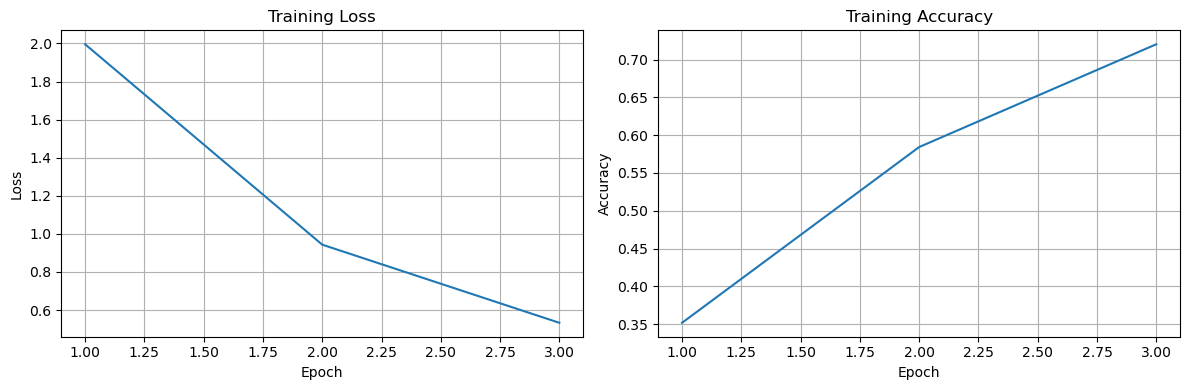

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, len(epoch_losses)+1), epoch_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, len(epoch_accs)+1), epoch_accs)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.savefig("training_curves_side_by_side.png", dpi=150)
plt.show()


In [8]:


@dataclass
class QAExample:
    id: str
    context: str
    question: str
    answers: Dict[str, List]

def _normalize(s: str) -> str:
    import string
    s = s.lower()
    s = "".join(ch for ch in s if ch not in set(string.punctuation))
    return " ".join(s.split())

def em(pred: str, gold: str) -> float:
    return float(_normalize(pred) == _normalize(gold))

def f1(pred: str, gold: str) -> float:
    p = _normalize(pred).split()
    g = _normalize(gold).split()
    common = (collections.Counter(p) & collections.Counter(g))
    num_same = sum(common.values())
    if not p and not g: return 1.0
    if not p or not g:  return 0.0
    if num_same == 0:   return 0.0
    prec, rec = num_same/len(p), num_same/len(g)
    return 2*prec*rec/(prec+rec)

def postprocess_predictions(examples: Dataset, features: Dataset, raw_preds: Tuple[np.ndarray, np.ndarray],
                            n_best=20, max_ans_len=30) -> Dict[str, str]:
    start_logits, end_logits = raw_preds
    ex_id_to_feats = collections.defaultdict(list)
    for i, f in enumerate(features):
        ex_id_to_feats[f["example_id"]].append(i)

    id_to_ctx = {ex["id"]: ex["context"] for ex in examples}
    preds_text = {}

    for qid, feat_idxs in ex_id_to_feats.items():
        best = None
        for fi in feat_idxs:
            s_log, e_log = start_logits[fi], end_logits[fi]
            offsets      = features[fi]["offset_mapping"]
            input_ids    = features[fi]["input_ids"]

            s_best = np.argsort(s_log)[-n_best:][::-1]
            e_best = np.argsort(e_log)[-n_best:][::-1]

            for si in s_best:
                for ei in e_best:
                    if si >= len(offsets) or ei >= len(offsets):        continue
                    if offsets[si] is None or offsets[ei] is None:      continue
                    if ei < si:                                         continue
                    if (ei - si + 1) > max_ans_len:                     continue
                    score = s_log[si] + e_log[ei]
                    if (best is None) or (score > best["score"]):
                        best = {"score": score, "si": si, "ei": ei, "fi": fi}

        if best is None:
            preds_text[qid] = ""
        else:
            ctx = id_to_ctx[qid]
            start_char = features[best["fi"]]["offset_mapping"][best["si"]][0]
            end_char   = features[best["fi"]]["offset_mapping"][best["ei"]][1]
            start_char = max(0, min(len(ctx), start_char))
            end_char   = max(0, min(len(ctx), end_char))
            preds_text[qid] = ctx[start_char:end_char]
    return preds_text

def _predict_logits_on_features(features, batch_size=32):
    model.eval()
    dl = DataLoader(
        features, batch_size=batch_size, shuffle=False,
        collate_fn=qa_collate, num_workers=2, pin_memory=torch.cuda.is_available()
    )
    all_start, all_end = [], []
    with torch.no_grad():
        for batch in tqdm(dl, desc="Evaluating", leave=True):
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch.get("token_type_ids", None),
            )
            all_start.append(outputs.start_logits.detach().cpu().numpy())
            all_end.append(outputs.end_logits.detach().cpu().numpy())
    start = np.concatenate(all_start, axis=0)
    end   = np.concatenate(all_end, axis=0)
    return start, end

def evaluate_split_verbose(split_name, raw_examples, tokenized_features, pred_file):
    print(f"Evaluating  {split_name} test set...")
    start_logits, end_logits = _predict_logits_on_features(tokenized_features, batch_size=32)
    preds_text = postprocess_predictions(raw_examples, tokenized_features, (start_logits, end_logits))

    with open(pred_file, "w", encoding="utf-8") as f:
        json.dump(preds_text, f, ensure_ascii=False, indent=2)

    ems, f1s = [], []
    for ex in raw_examples:
        if ex["answers"]["text"] and ex["answers"]["text"][0]:
            gold = ex["answers"]["text"][0]
            pred = preds_text.get(ex["id"], "")
            ems.append(em(pred, gold))
            f1s.append(f1(pred, gold))
    f1_score = (np.mean(f1s)*100) if f1s else 0.0
    em_score = (np.mean(ems)*100) if ems else 0.0

    print(f"Results  {split_name}:")
    print(f"F1 Score: {f1_score:.2f}%")
    print(f"EM Score: {em_score:.2f}%\n")
    return {"EM": em_score, "F1": f1_score}


scores_clean = evaluate_split_verbose("No Noise", raw["clean"], tok_clean, "predictions_clean.json")
scores_w44   = evaluate_split_verbose("WER 44",  raw["wer44"], tok_w44,   "predictions_wer44.json")
scores_w54   = evaluate_split_verbose("WER 54",  raw["wer54"], tok_w54,   "predictions_wer54.json")


Evaluating  No Noise test set...


Evaluating: 100%|██████████| 170/170 [00:34<00:00,  4.92it/s]


Results  No Noise:
F1 Score: 68.20%
EM Score: 49.86%

Evaluating  WER 44 test set...


Evaluating: 100%|██████████| 170/170 [00:34<00:00,  4.92it/s]


Results  WER 44:
F1 Score: 48.76%
EM Score: 29.88%

Evaluating  WER 54 test set...


Evaluating: 100%|██████████| 170/170 [00:34<00:00,  4.92it/s]


Results  WER 54:
F1 Score: 36.58%
EM Score: 20.46%

